In [1]:
def stop_check(dataframe,rules,level,direction):
    """
    Funzione per validare una regola di ingresso o di uscita rispetto ad un setup stop
    """
    service_dataframe = pd.DataFrame(index = dataframe.index)
    service_dataframe['rules'] = rules
    service_dataframe['level'] = level
    service_dataframe['low'] = dataframe.low
    service_dataframe['high'] = dataframe.high

    if direction == "long":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) &\
                                         (service_dataframe.high.shift(-1) >= service_dataframe.level.shift(-1)), 
                                          True, False)
    if direction == "short":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) &\
                                         (service_dataframe.low.shift(-1) <= service_dataframe.level.shift(-1)), 
                                          True, False)
    return service_dataframe.new_rules

def limit_check(dataframe,rules,level,direction):
    """
    Funzione per validare una regola di ingresso o di uscita rispetto ad un setup limit
    """
    service_dataframe = pd.DataFrame()
    service_dataframe['rules'] = rules
    service_dataframe['level'] = level
    service_dataframe['low'] = dataframe.low
    service_dataframe['high'] = dataframe.high
    
    if direction == "long":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) & \
                                         (service_dataframe.low.shift(-1) <= service_dataframe.level.shift(-1)), 
                                          True, False)
    if direction == "short":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) &
                                         (service_dataframe.high.shift(-1) >= service_dataframe.level.shift(-1)), 
                                          True, False)
    return service_dataframe.new_rules

In [2]:
def marketposition_generator(enter_rules,exit_rules):
    """
    Funzione per calcolare il marketposition date due serie di enter_rules and exit_rules
    """
    service_dataframe = pd.DataFrame(index = enter_rules.index)
    service_dataframe['enter_rules'] = enter_rules
    service_dataframe['exit_rules'] = exit_rules
    
    status = 0
    mp = []
    for (i, j) in zip(enter_rules, exit_rules):
        if status == 0:
            if i == 1 and j != -1:
                status = 1
        else:
            if j == -1:
                status = 0
        mp.append(status)
        
    service_dataframe['mp_new'] = mp
    service_dataframe.mp_new = service_dataframe.mp_new.shift(1)
    service_dataframe.iloc[0,2] = 0
    service_dataframe.to_csv("marketposition_generator.csv")
    return service_dataframe.mp_new

In [3]:
import math

def tick_correction_up(level,tick):
    if level != level:
        level = 0
    multiplier = math.ceil(level/tick)
    return multiplier * tick

def tick_correction_down(level,tick):
    if level != level:
        level = 0
    multiplier = math.floor(level/tick)
    return multiplier * tick

TICK = 0.01
print(tick_correction_up(320.677,TICK))
print(tick_correction_down(320.677,TICK))

320.68
320.67


In [5]:
def apply_trading_system(imported_dataframe, tick, direction, order_type, enter_level, enter_rules, exit_rules):
    dataframe = imported_dataframe.copy()
    if ORDER_TYPE == "stop":
        enter_rules = stop_check(dataframe,enter_rules,enter_level,direction)
    if ORDER_TYPE == "limit":
        enter_rules = limit_check(dataframe,enter_rules,enter_level,direction)
        
    dataframe['enter_level'] = enter_level
    dataframe['enter_rules'] = enter_rules.apply(lambda x: 1 if x == True else 0)
    dataframe['exit_rules'] = exit_rules.apply(lambda x: -1 if x == True else 0)

    dataframe["mp"] = marketposition_generator(dataframe.enter_rules,dataframe.exit_rules)
 
    if ORDER_TYPE == "market":
        dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                             dataframe.open, np.nan)
        if INSTRUMENT == 1:
            dataframe["number_of_stocks"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                      OPERATION_MONEY / dataframe.open, np.nan)
    if ORDER_TYPE == "stop":
        if direction == "long":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_up(x,tick))
            real_entry = np.where(dataframe.open > dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if direction == "short":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_down(x,tick))
            real_entry = np.where(dataframe.open < dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if INSTRUMENT == 1:
            dataframe["number_of_stocks"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                      OPERATION_MONEY / real_entry, np.nan)   
    if ORDER_TYPE == "limit":
        if direction == "long":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_down(x,tick))
            real_entry = np.where(dataframe.open < dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if direction == "short":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_up(x,tick))
            real_entry = np.where(dataframe.open > dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if INSTRUMENT == 1:
            dataframe["number_of_stocks"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                      OPERATION_MONEY / real_entry, np.nan) 
            
    dataframe["entry_price"] = dataframe["entry_price"].fillna(method='ffill')
    dataframe["events_in"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(1) == 0), "entry", "")
    if INSTRUMENT == 1:
        dataframe["number_of_stocks"] = dataframe["number_of_stocks"].apply(lambda x: round(x,0))\
                                        .fillna(method='ffill')

    if direction == "long":
        if INSTRUMENT == 1:
            dataframe["open_operations"] = (dataframe.close - dataframe.entry_price) * dataframe.number_of_stocks
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                                                    (dataframe.open.shift(-1) - dataframe.entry_price)
                                                    * dataframe.number_of_stocks - 2 * COSTS, 
                                                    dataframe.open_operations)
    else:
        if INSTRUMENT == 1:
            dataframe["open_operations"] = (dataframe.entry_price - dataframe.close) * dataframe.number_of_stocks
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                                            (dataframe.entry_price - dataframe.open.shift(-1))\
                                            * dataframe.number_of_stocks - 2 * COSTS,
                                            dataframe.open_operations)
        
    dataframe["open_operations"] = np.where(dataframe.mp == 1, dataframe.open_operations, 0)
    dataframe["events_out"] = np.where((dataframe.mp == 1) & (dataframe.exit_rules == -1), "exit", "")      
    dataframe["operations"] = np.where((dataframe.exit_rules == -1) & (dataframe.mp == 1), 
                                        dataframe.open_operations, np.nan)
    dataframe["closed_equity"] = dataframe.operations.fillna(0).cumsum()
    dataframe["open_equity"] = dataframe.closed_equity + \
                               dataframe.open_operations - dataframe.operations.fillna(0)
    dataframe.to_csv("trading_system_export.csv")
    return dataframe

# Funzioni utilizzate:

In [6]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 99999

def load_data(filename):
    """
    Funzione per il parsing di una serie intraday 
    con estensione txt esportata da Tradestation
    """
    data = pd.read_csv(filename, 
                       usecols=['Date','Time','Open','High','Low','Close','Up','Down'], 
                       parse_dates=[['Date', 'Time']], )
    data.columns = ["date_time","open","high","low","close","up","down"]
    data.set_index('date_time', inplace = True)
    data['volume'] = data['up'] + data['down']
    data.drop(['up','down'],axis=1,inplace=True)
    data["dayofweek"] = data.index.dayofweek
    data["day"] = data.index.day
    data["month"] = data.index.month
    data["year"] = data.index.year
    data["dayofyear"] = data.index.dayofyear
    data["quarter"] = data.index.quarter
    data["hour"] = data.index.hour
    data["minute"] = data.index.minute
    return data

def load_data_daily(filename):
    """
    Funzione per il caricamento di uno storico daily
    Fonte dati: Tradestation .txt
    """
    data = pd.read_csv(filename, parse_dates = ["Date","Time"])
    data.columns = ["date","time","open","high","low","close","volume","oi"]
    data.set_index("date", inplace = True)
    data.drop(["time","oi"], axis=1, inplace=True)
    data["dayofweek"] = data.index.dayofweek
    data["day"] = data.index.day
    data["month"] = data.index.month
    data["year"] = data.index.year
    data["dayofyear"] = data.index.dayofyear
    data["quarter"] = data.index.quarter
    return data
    
def crossover(array1, array2):
    return (array1 > array2) & (array1.shift(1) < array2.shift(1))

def crossunder(array1, array2):
    return (array1 < array2) & (array1.shift(1) > array2.shift(1))
        
def plot_equity(equity,color):
    """
    Funzione per stampare un'equity line
    """
    plt.figure(figsize=(14, 8), dpi=300)
    plt.plot(equity, color=color)
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Equity Line')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return
    
def drawdown(equity):
    """
    Funzione che calcola il draw down data un'equity line
    """
    maxvalue = equity.expanding(0).max()
    drawdown = equity - maxvalue
    drawdown_series = pd.Series(drawdown, index = equity.index)
    return drawdown_series

def plot_drawdown(equity,color):
    """
    Funzione per graficare la curva di draw down
    """
    dd = drawdown(equity)
    plt.figure(figsize = (12, 6), dpi = 300)
    plt.plot(dd, color = color)
    plt.fill_between(dd.index, 0, dd, color = color)
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Draw Down')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return
    
def plot_double_equity(closed_equity,open_equity):
    """
    Funzione per stampare due equity sovrapposte
    """
    plt.figure(figsize=(14, 8), dpi=300)
    plt.plot(open_equity, color='red')
    plt.plot(closed_equity, color='green')
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Open & Closed Equity Line')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return
    
def profit(equity):
    return round(equity[-1],2)
    
def operation_number(operations):
    return operations.count()
    
def avg_trade(operations):
    return round(operations.mean(),2)
    
def max_draw_down(equity):
    dd = drawdown(equity)
    return round(dd.min(),2)
    
def avgdrawdown_nozero(equity):
    """
    calcola la media del draw down storico
    non considerando i valori nulli (nuovi massimi di equity line)
    """
    dd = drawdown(equity)
    return round(dd[dd < 0].mean(),2)

def avg_loss(operations):
    return round(operations[operations < 0].mean(),2)
    
def max_loss(operations):
    return round(operations.min(),2)
    
def max_loss_date(operations):
    return operations.idxmin()
    
def avg_gain(operations):
    return round(operations[operations > 0].mean(),2)
    
def max_gain(operations):
    return round(operations.max(),2)
    
def max_gain_date(operations):
    return operations.idxmax()
    
def gross_profit(operations):
    return round(operations[operations > 0].sum(),2)
    
def gross_loss(operations):
    return round(operations[operations <= 0].sum(),2)
    
def profit_factor(operations):
    a = gross_profit(operations)
    b = gross_loss(operations)
    if b != 0:
        return round(abs(a / b), 2)
    else:
        return round(abs(a / 0.00000001), 2)
        
def percent_win(operations):
    return round((operations[operations > 0].count() / operations.count() * 100),2)
    
def reward_risk_ratio(operations):
    if operations[operations <= 0].mean() != 0:
        return round((operations[operations > 0].mean() / -operations[operations <= 0].mean()),2)
    else:
        return np.inf
        
def delay_between_peaks(equity):
    """
    Funzione per calcolare i ritardi istantanei in barre
    nel conseguire nuovi massimi di equity line
    Input: equity line
    """
    work_df = pd.DataFrame(equity, index = equity.index)
    work_df["drawdown"] = drawdown(equity)
    work_df["delay_elements"] = work_df["drawdown"].apply(lambda x: 1 if x < 0 else 0)
    work_df["resets"] = np.where(work_df["drawdown"] == 0, 1, 0)
    work_df['cumsum'] = work_df['resets'].cumsum()
    #print(work_df.iloc[-20:,:])
    a = pd.Series(work_df['delay_elements'].groupby(work_df['cumsum']).cumsum())
    return a

def max_delay_between_peaks(equity):
    """
    Funzione per calcolare il più lungo ritardo in barre dall'ultimo massimo
    Input: equity line
    """
    a = delay_between_peaks(equity)
    return a.max()
    
def avg_delay_between_peaks(equity):
    """
    Funzione per calcolare il ritardo medio in barre
    nel conseguire nuovi massimi di equity line
    Input: equity line
    """
    work_df = pd.DataFrame(equity, index = equity.index)
    work_df["drawdown"] = drawdown(equity)
    work_df["delay_elements"] = work_df["drawdown"].apply(lambda x: 1 if x < 0 else np.nan)
    work_df["resets"] = np.where(work_df["drawdown"] == 0, 1, 0)
    work_df['cumsum'] = work_df['resets'].cumsum()
    work_df.dropna(inplace = True)
    a = work_df['delay_elements'].groupby(work_df['cumsum']).sum()
    return round(a.mean(),2)
    
def plot_annual_histogram(operations):
    yearly = operations.resample('A').sum()
    colors = pd.Series()
    colors = yearly.apply(lambda x: "green" if x > 0 else "red")
    n_groups = len(yearly)
    plt.subplots(figsize=(10, 7), dpi=200)
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 1

    rects1 = plt.bar(index,
                     yearly,
                     bar_width,
                     alpha=opacity,
                     color=colors,
                     label='Yearly Statistics')

    plt.xlabel('Years')
    plt.ylabel('Profit - Loss')
    plt.title('Yearly Profit-Loss - by Gandalf Project R&D')
    plt.xticks(index, yearly.index.year, rotation=90)
    plt.grid(True)
    plt.show()
    return
    
def plot_monthly_bias_histogram(operations):
    monthly = pd.DataFrame(operations.fillna(0)).resample('M').sum()
    monthly['Month'] = monthly.index.month
    biasMonthly = []
    months = []

    for month in range(1, 13):
        months.append(month)
    for month in months:
        biasMonthly.append(monthly[(monthly['Month'] == month)].mean())

    biasMonthly = pd.DataFrame(biasMonthly)
    column = biasMonthly.columns[0]
    colors = pd.Series()
    colors = biasMonthly[column].apply(lambda x: "green" if x > 0 else "red")
    n_groups = len(biasMonthly)
    plt.subplots(figsize=(14, 6), dpi=300)
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 1

    rects1 = plt.bar(index,
                     biasMonthly[column],
                     bar_width,
                     alpha=opacity,
                     color=colors,
                     label='Yearly Statistics')

    plt.xlabel('Months')
    plt.ylabel('Average Profit - Loss')
    plt.title('Average Monthly Profit-Loss - by Gandalf Project R&D')
    months_names = ["January", "February", "March", "April", "May", "June", "July", "August", "September",
                    "October", "November", "December"]
    plt.xticks(index, months_names, rotation=45)
    plt.grid(True)
    plt.show()
    return
    
def plot_equity_heatmap(operations,annotations):
    monthly = operations.resample('M').sum()
    toHeatMap = pd.DataFrame(monthly)
    toHeatMap["Year"] = toHeatMap.index.year
    toHeatMap["Month"] = toHeatMap.index.month
    Show = toHeatMap.groupby(by=['Year','Month']).sum().unstack()
    Show.columns = ["January","February","March","April","May","June",
                    "July","August","September","October","November","December"]
    plt.figure(figsize=(8,6),dpi=120)
    sns.heatmap(Show, cmap="RdYlGn", linecolor="white", linewidth=0.1, annot=annotations, 
                vmin=-max(monthly.min(),monthly.max()), vmax=monthly.max())
    return
    
def performance_report(trading_system,operations,closed_equity,open_equity):
    print("Performance Report - by Gandalf Project R&D")
    print("")
    print("Profit:                  ", profit(open_equity))
    print("Operations:              ", operation_number(operations))
    print("Average Trade:           ", avg_trade(operations))
    print("")
    print("Profit Factor:           ", profit_factor(operations))
    print("Gross Profit:            ", gross_profit(operations))
    print("Gross Loss:              ", gross_loss(operations))
    print("")
    print("Percent Winning Trades:  ", percent_win(operations))
    print("Percent Losing Trades:   ", 100 - percent_win(operations))
    print("Reward Risk Ratio:       ", reward_risk_ratio(operations))
    print("")
    print("Max Gain:                ", max_gain(operations), " in date ", max_gain_date(operations))
    print("Average Gain:            ", avg_gain(operations))
    print("Max Loss:                ", max_loss(operations), " in date ", max_loss_date(operations))
    print("Average Loss:            ", avg_loss(operations))
    print("")
    print("Avg Open Draw Down:      ", avgdrawdown_nozero(open_equity))
    print("Max Open Draw Down:      ", max_draw_down(open_equity))
    print("")
    print("Avg Closed Draw Down:    ", avgdrawdown_nozero(trading_system.closed_equity))
    print("Max Closed Draw Down:    ", max_draw_down(trading_system.closed_equity))
    print("")
    print("Avg Delay Between Peaks: ", avg_delay_between_peaks(trading_system.open_equity))
    print("Max Delay Between Peaks: ", max_delay_between_peaks(trading_system.open_equity))
    plot_equity(trading_system.open_equity,"green")
    plot_drawdown(trading_system.open_equity,"red")
    plot_annual_histogram(operations)
    plot_monthly_bias_histogram(operations)
    plot_equity_heatmap(operations,False)
    return

Performance Report - by Gandalf Project R&D

Profit:                   42016.18
Operations:               184
Average Trade:            228.35

Profit Factor:            2.44
Gross Profit:             71278.43
Gross Loss:               -29262.25

Percent Winning Trades:   55.43
Percent Losing Trades:    44.57
Reward Risk Ratio:        1.96

Max Gain:                 3345.46  in date  2004-11-01 00:00:00
Average Gain:             698.81
Max Loss:                 -1508.49  in date  2001-07-18 00:00:00
Average Loss:             -365.78

Avg Open Draw Down:       -1152.89
Max Open Draw Down:       -6596.22

Avg Closed Draw Down:     -1185.37
Max Closed Draw Down:     -6415.5

Avg Delay Between Peaks:  33.41
Max Delay Between Peaks:  828


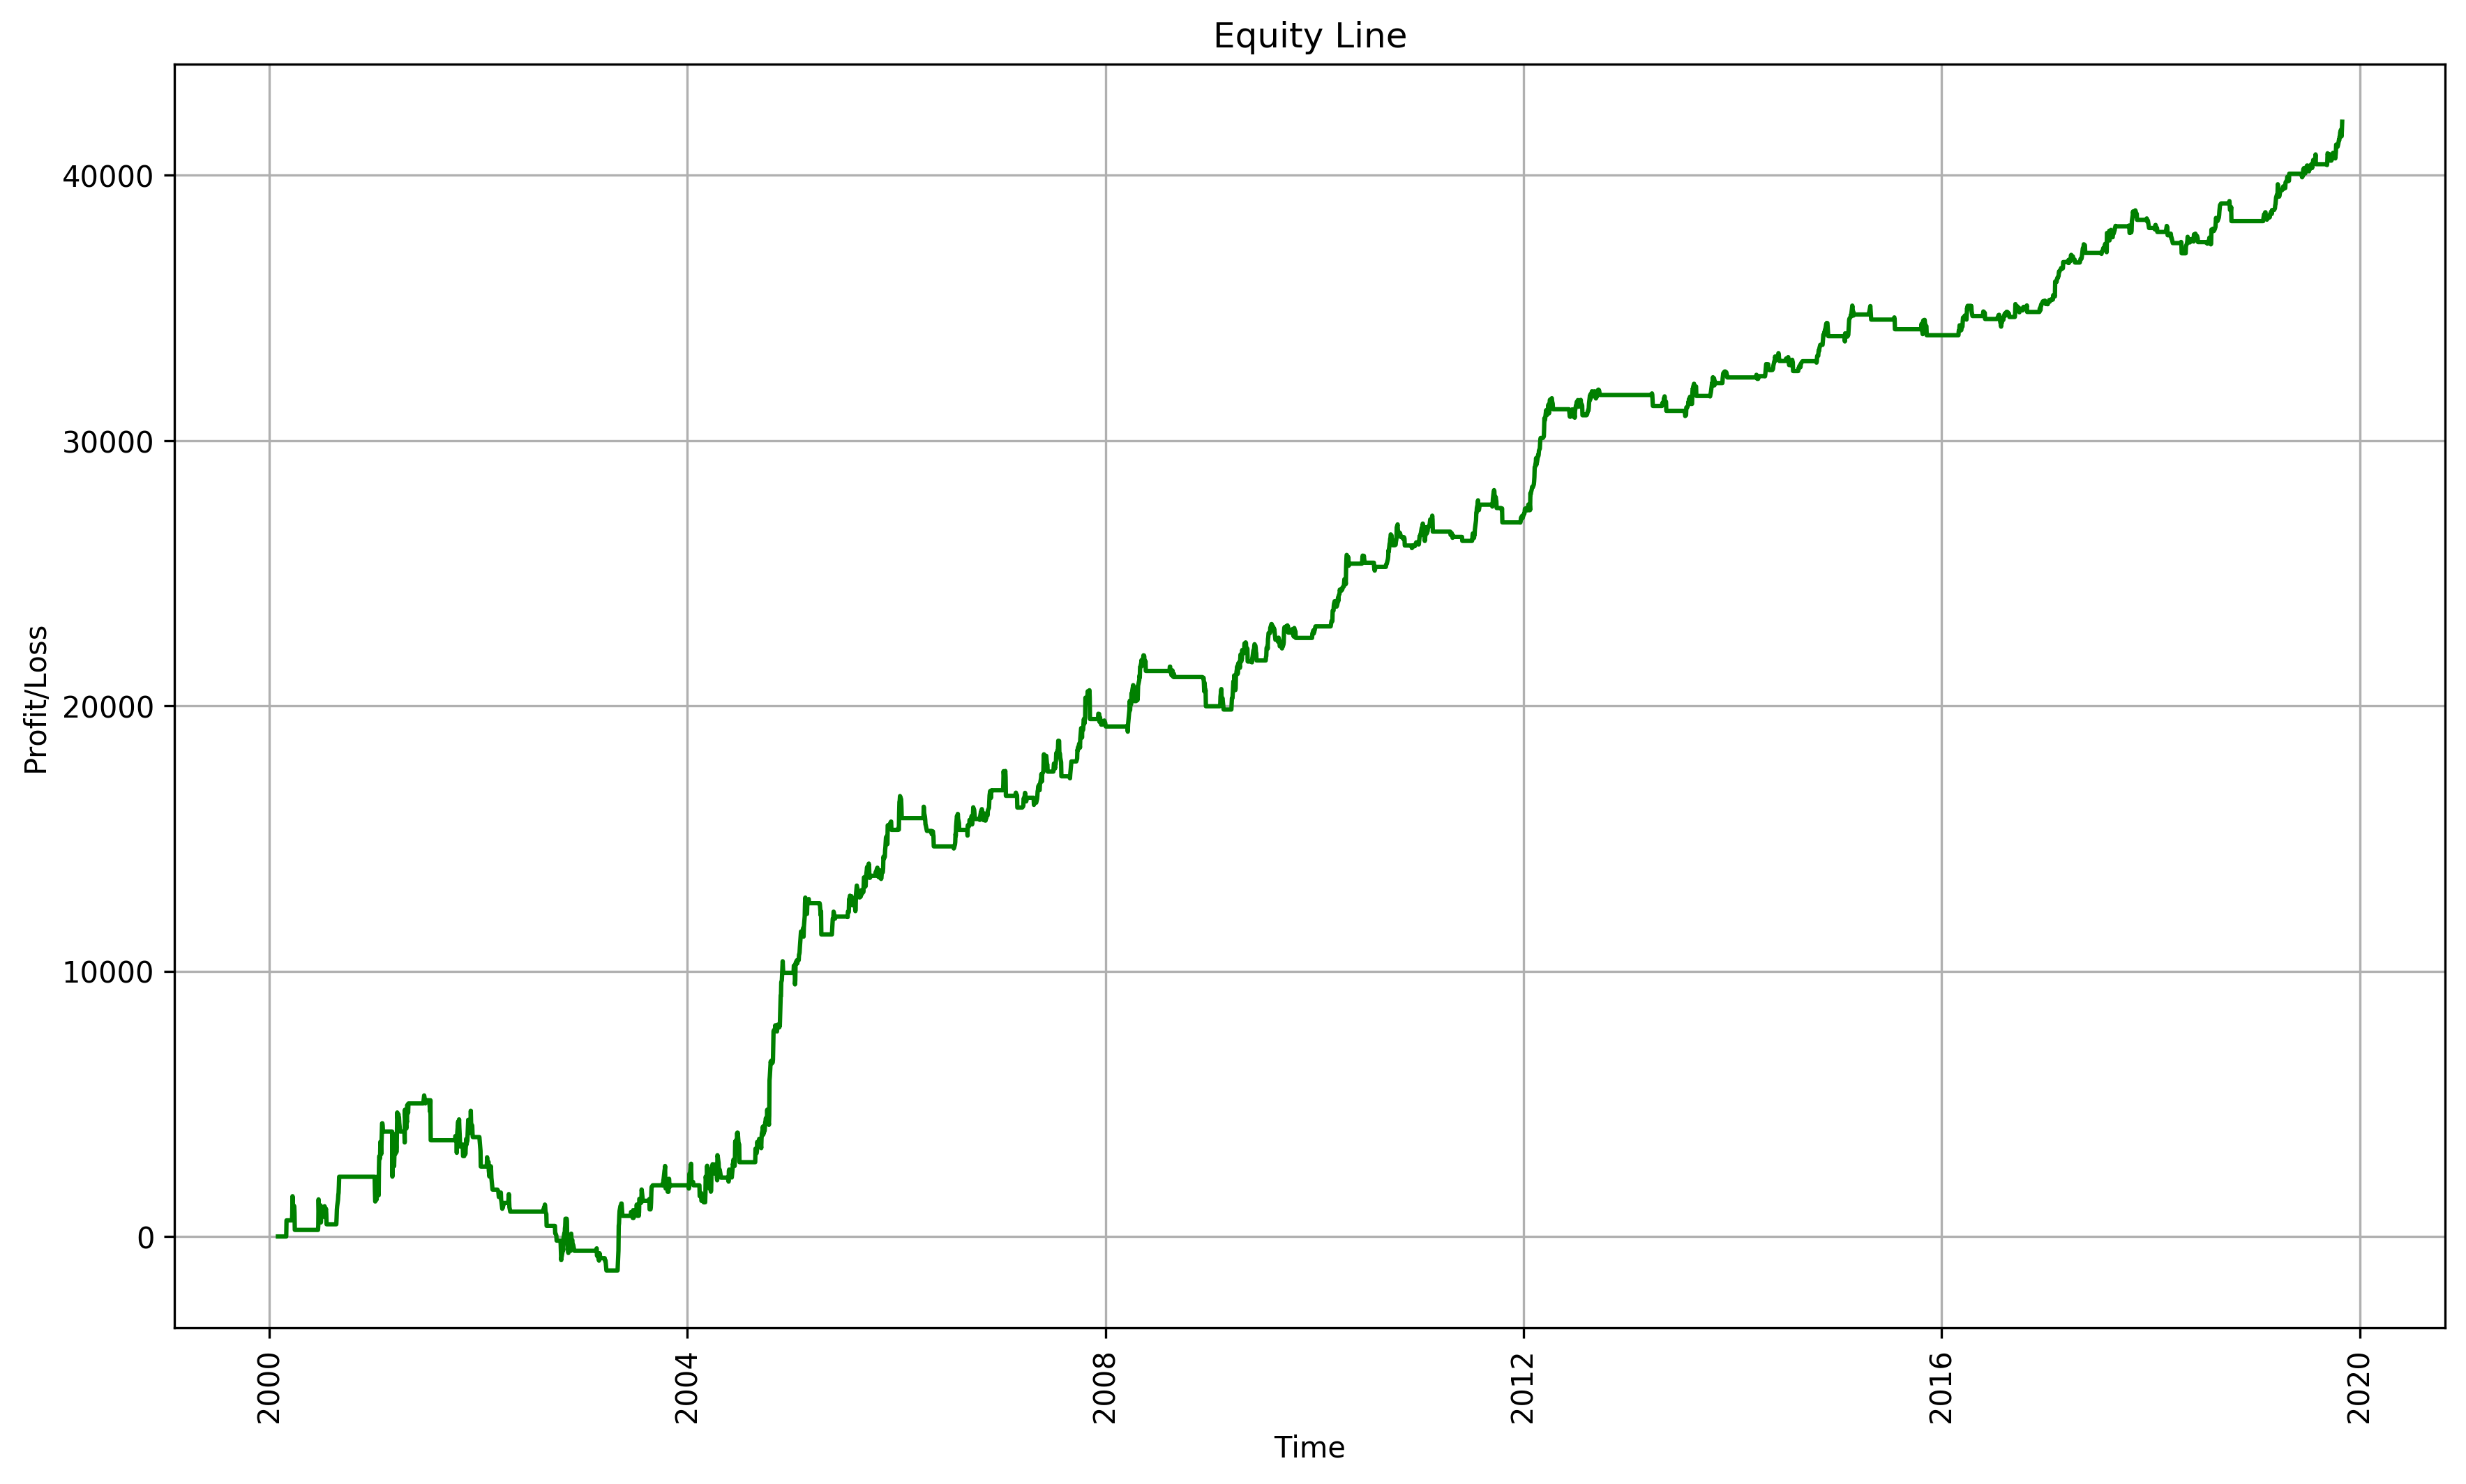

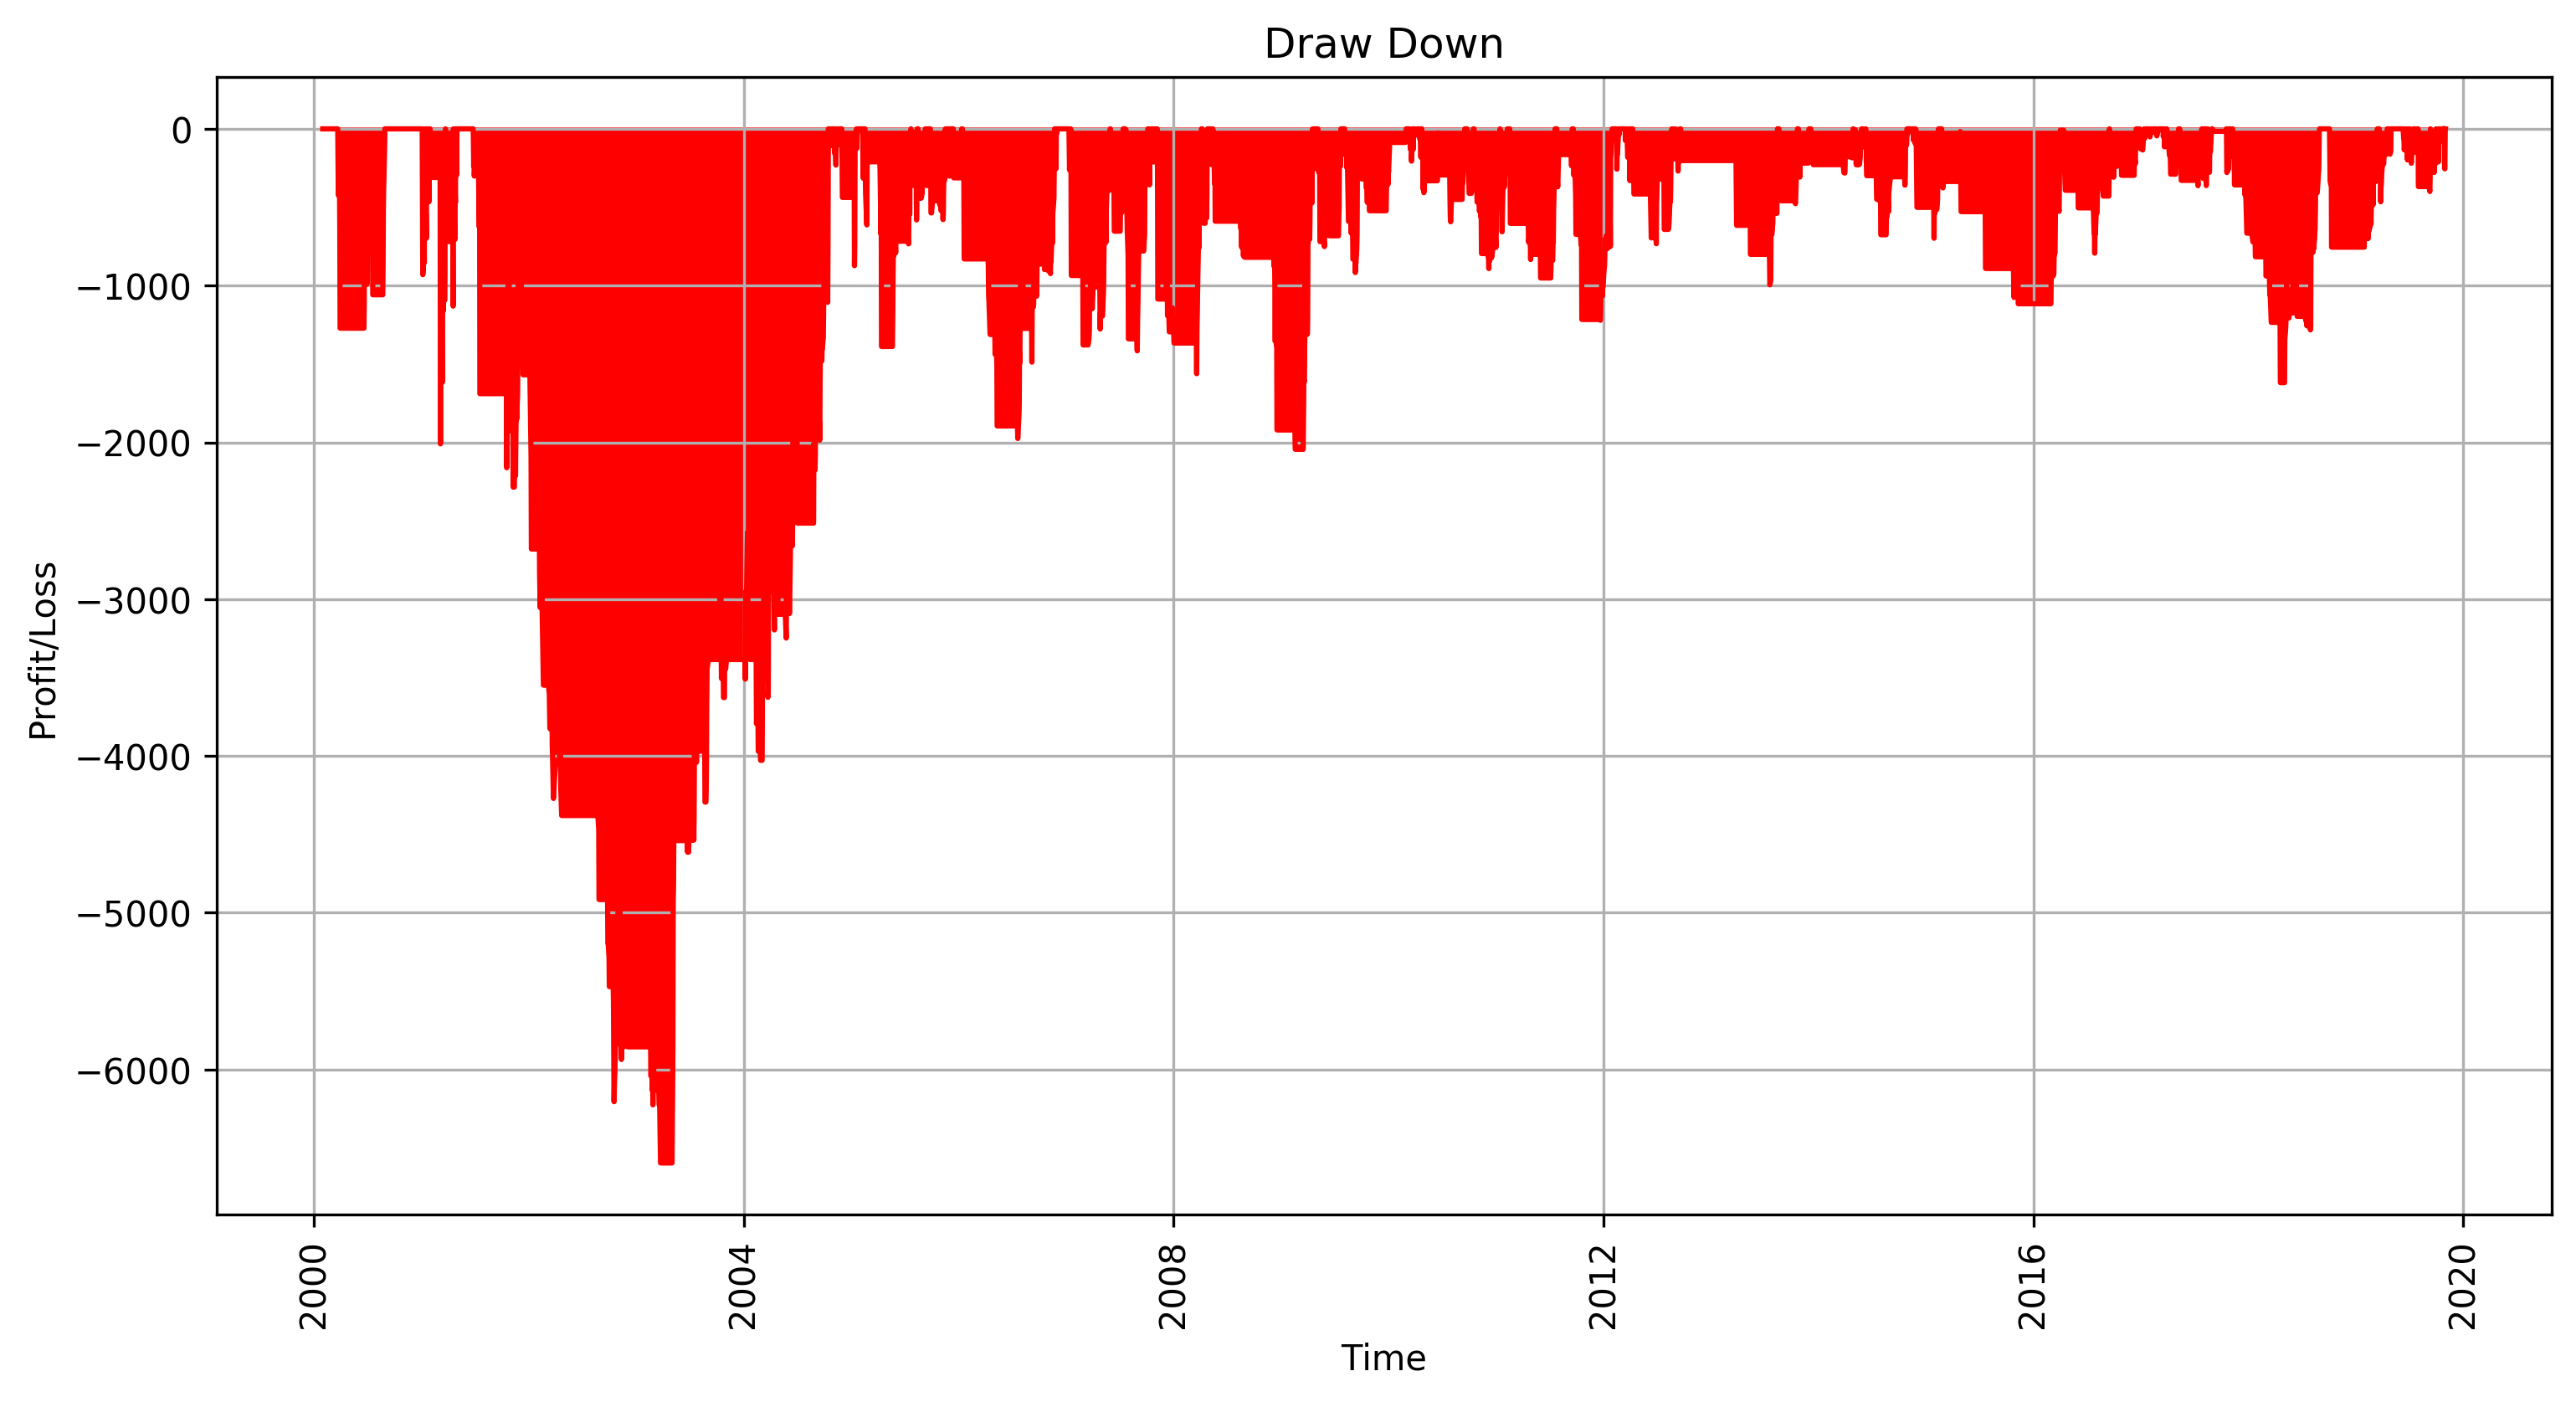

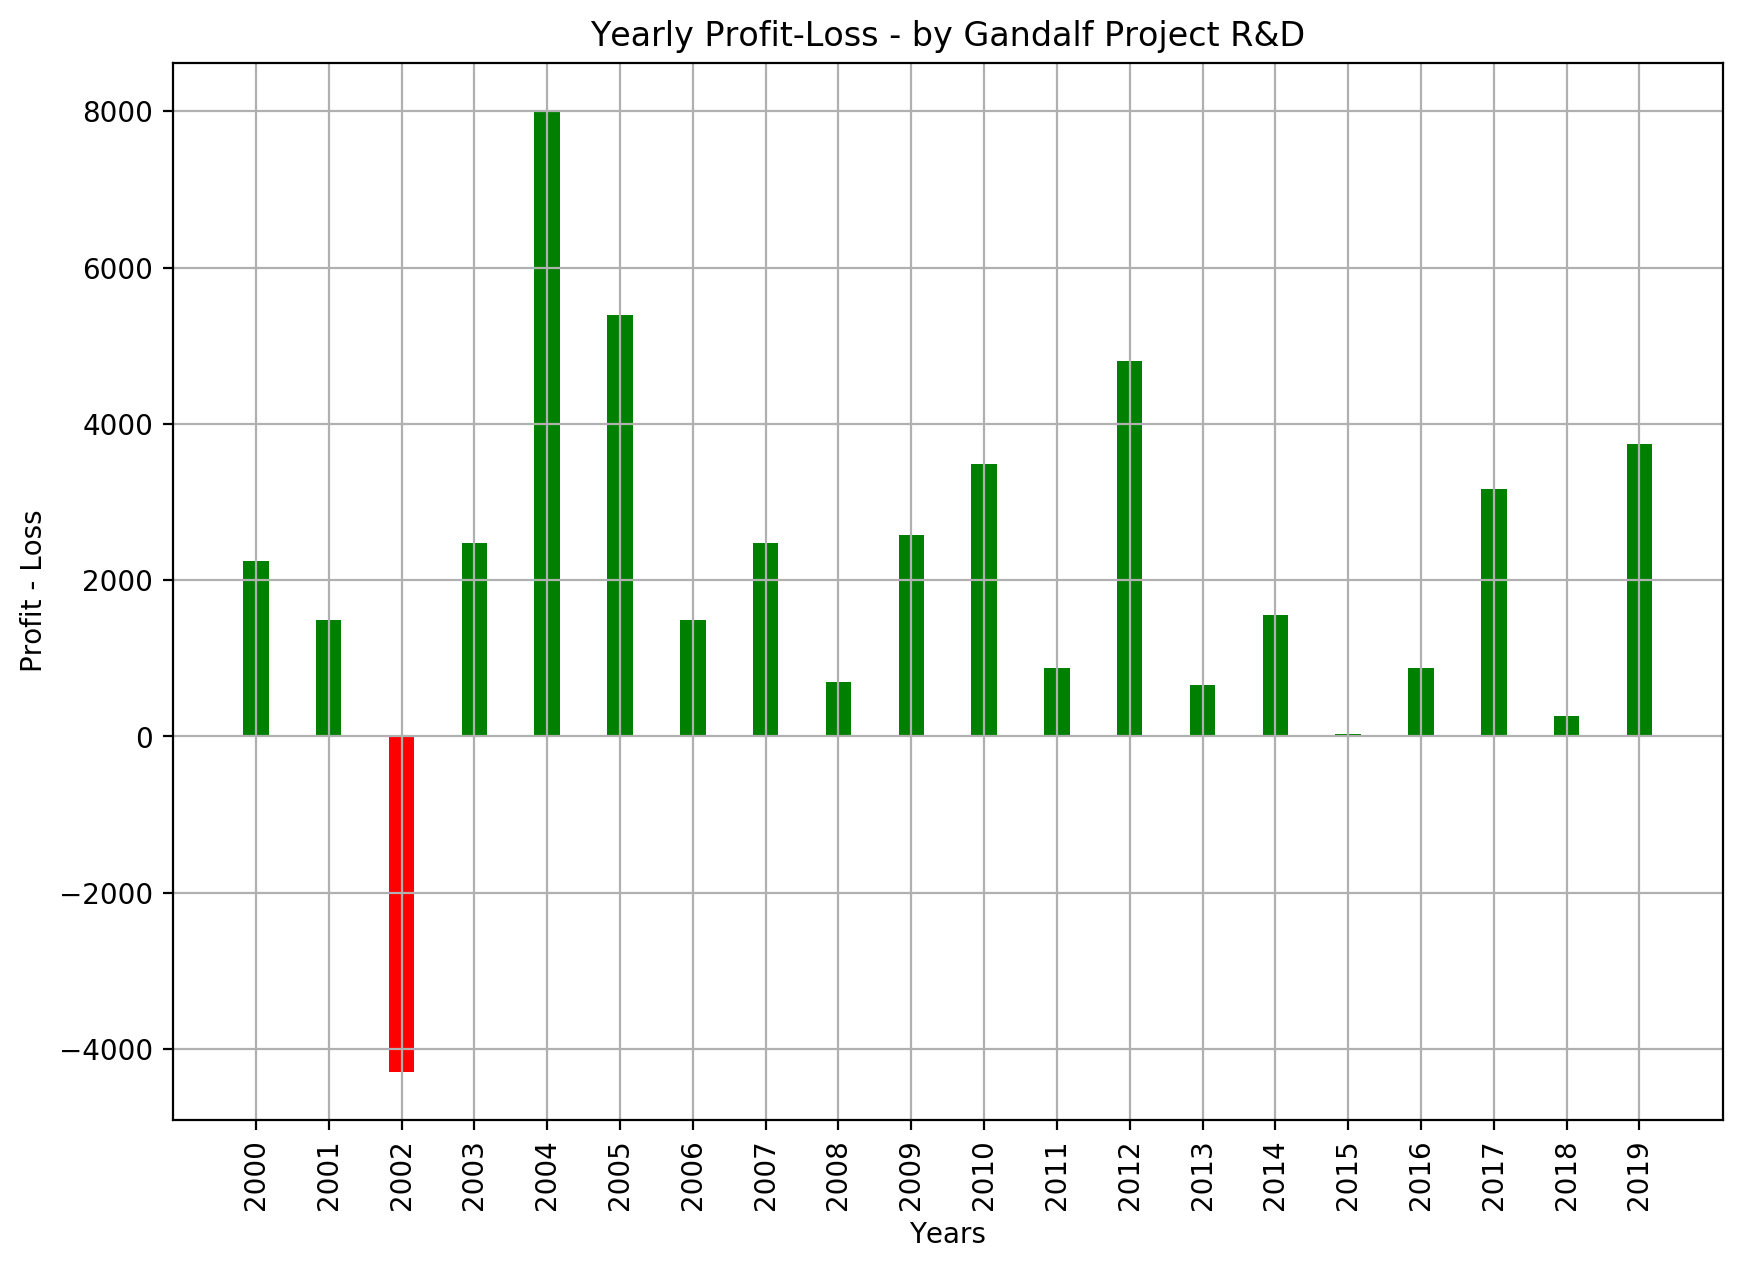

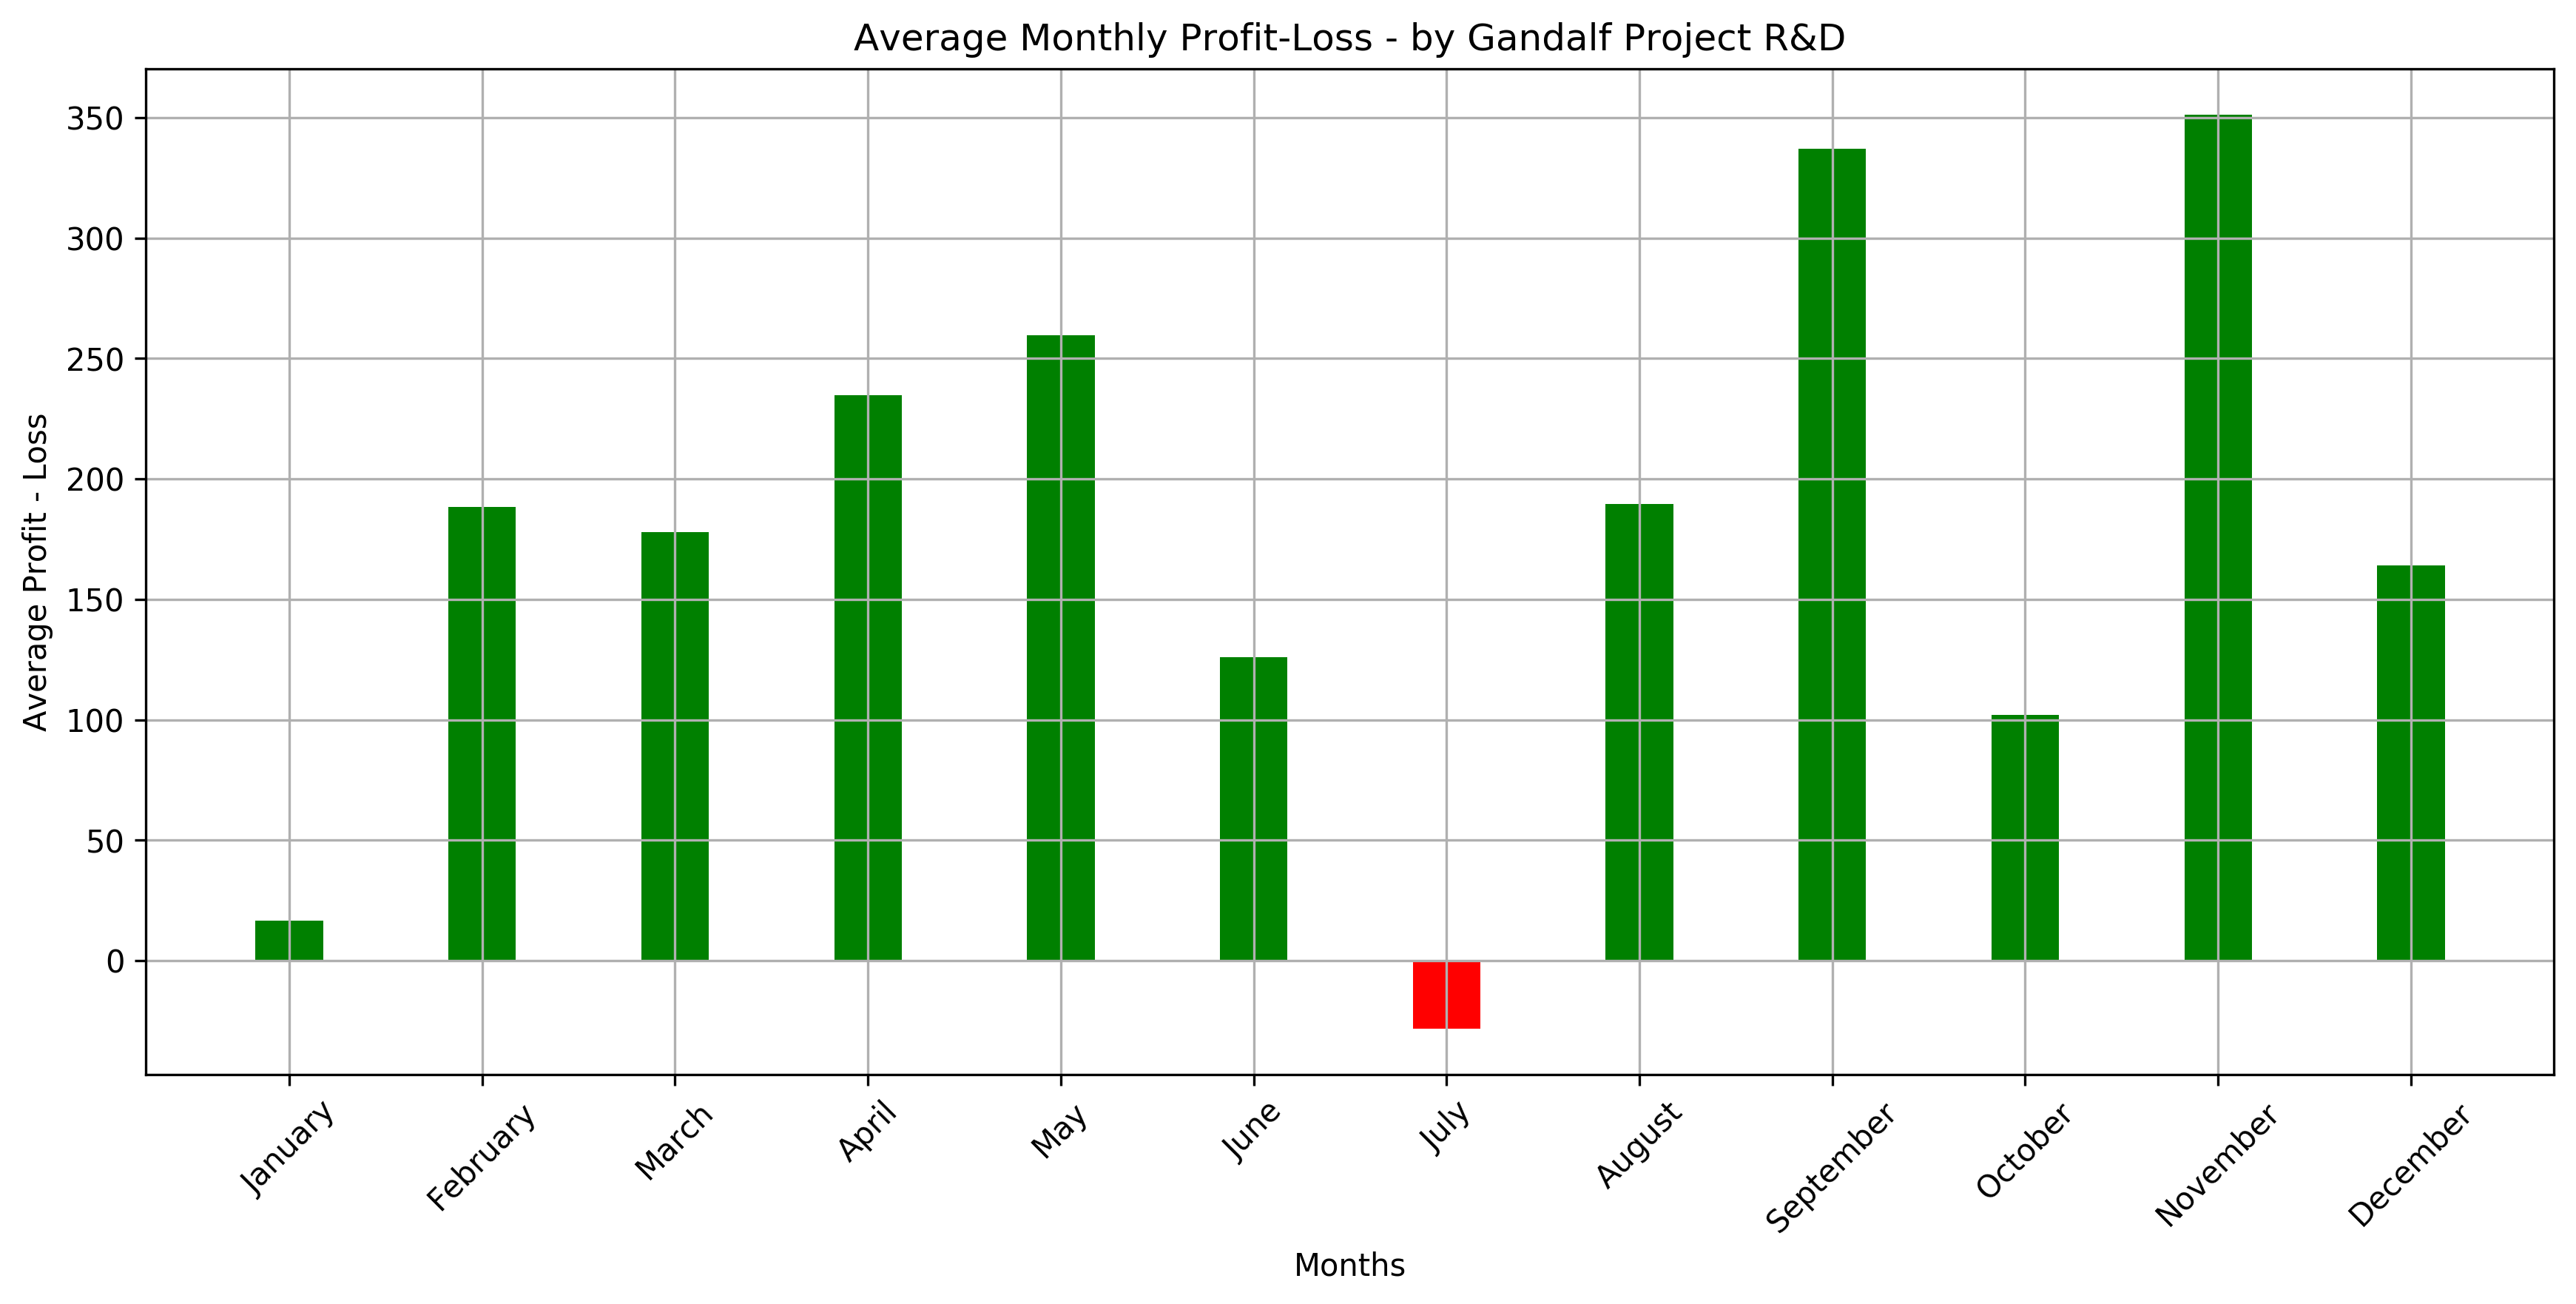

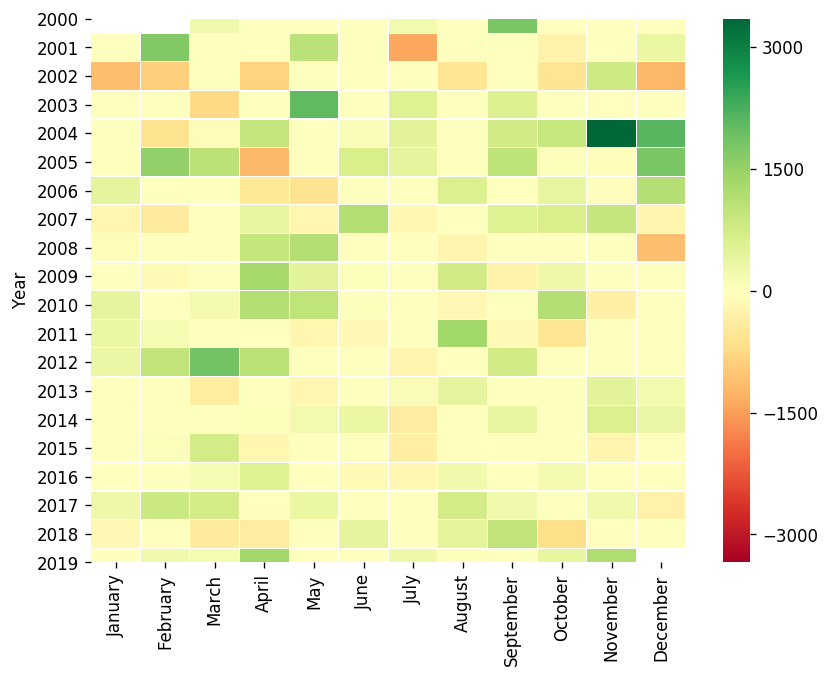

In [9]:
dataset = load_data_daily("AAPL_Daily.txt")

dataset["hhv20"] = dataset.high.rolling(20).max()
dataset["llv20"] = dataset.low.rolling(20).min()
dataset["hhv5"] = dataset.high.rolling(5).max()
dataset["llv5"] = dataset.low.rolling(5).min()
dataset.dropna(inplace=True)

COSTS = 0
INSTRUMENT = 1 # 1: equity/forex, 2: future
TICK = 0.01
OPERATION_MONEY = 10000
DIRECTION = "long"
ORDER_TYPE = "stop"

enter_rules = dataset.close > 0
enter_level = dataset.hhv20.shift(1)
exit_rules = crossunder(dataset.close,dataset.llv5.shift(1)) | (dataset.day < dataset.day.shift(1))

trading_system = apply_trading_system(dataset, TICK, DIRECTION, ORDER_TYPE, enter_level, enter_rules, exit_rules)

operations = trading_system.operations.dropna()

performance_report(trading_system,operations,trading_system.closed_equity,trading_system.open_equity);

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide


Performance Report - by Gandalf Project R&D

Profit:                   55268.56
Operations:               181
Average Trade:            305.35

Profit Factor:            2.33
Gross Profit:             96848.58
Gross Loss:               -41580.02

Percent Winning Trades:   32.6
Percent Losing Trades:    67.4
Reward Risk Ratio:        4.82

Max Gain:                 10270.4  in date  2013-02-22 00:00:00
Average Gain:             1641.5
Max Loss:                 -2384.34  in date  2004-07-16 00:00:00
Average Loss:             -343.64

Avg Open Draw Down:       -2611.27
Max Open Draw Down:       -5368.49

Avg Closed Draw Down:     -1837.22
Max Closed Draw Down:     -3778.66

Avg Delay Between Peaks:  51.22
Max Delay Between Peaks:  616


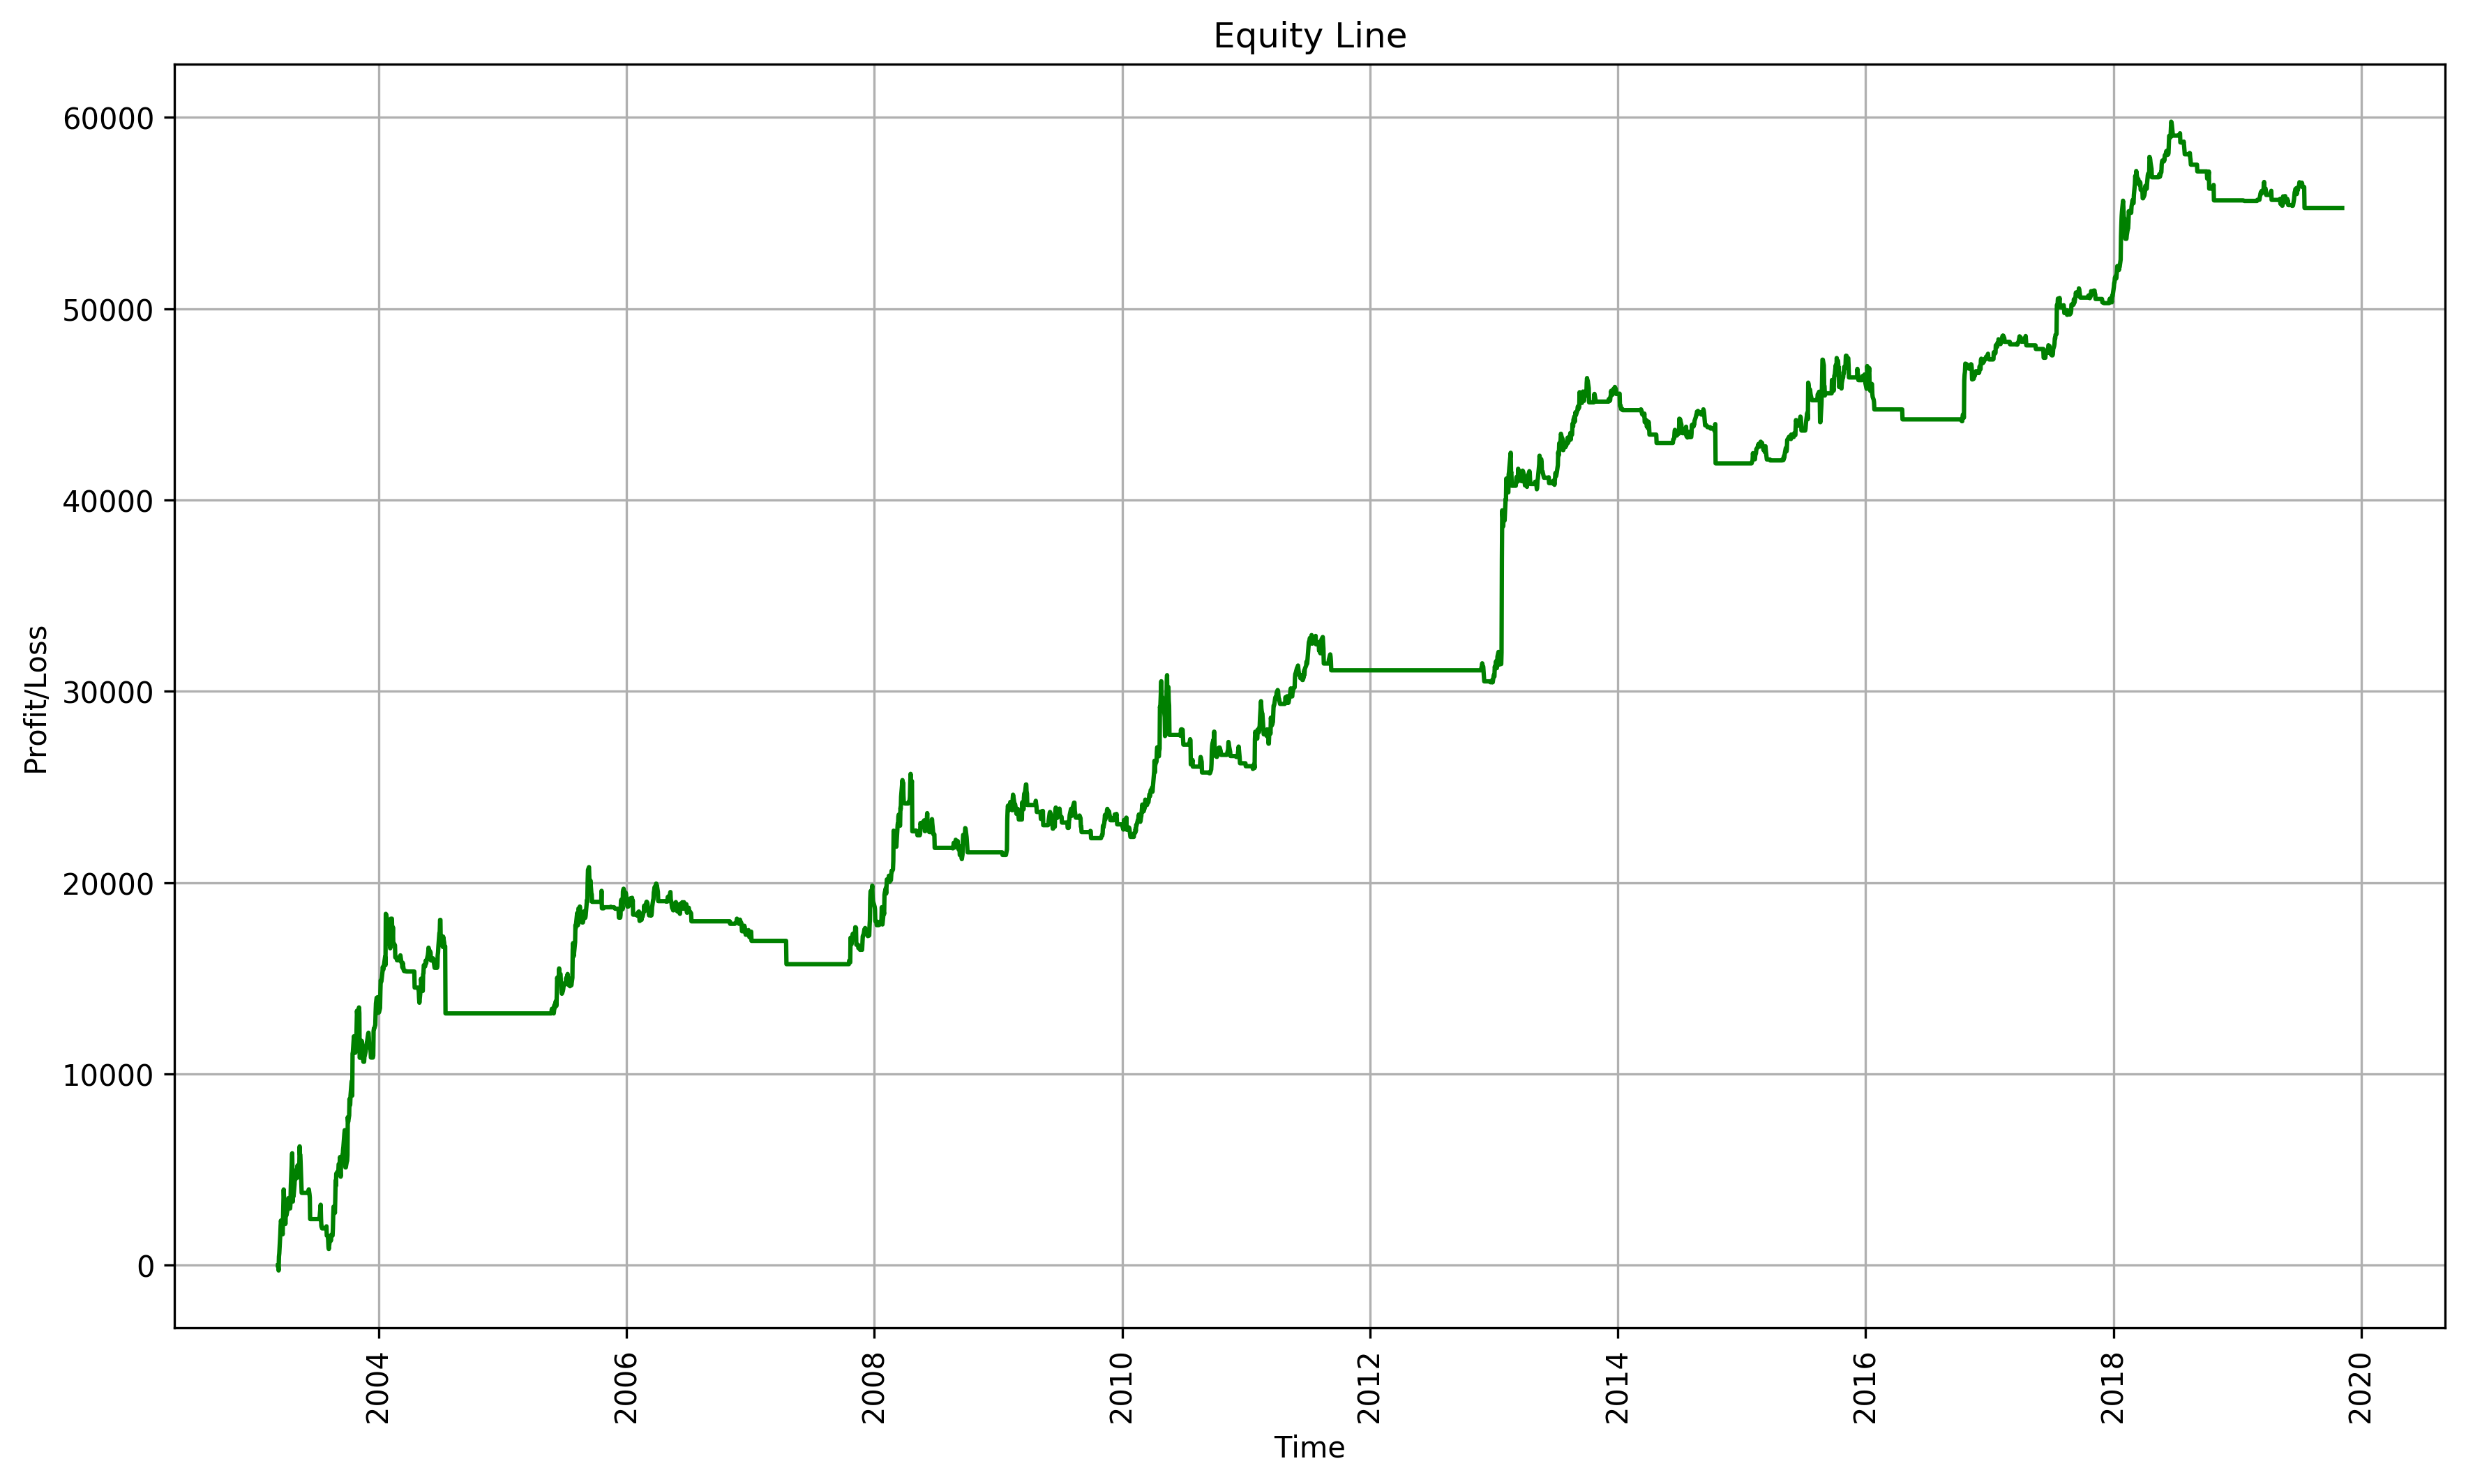

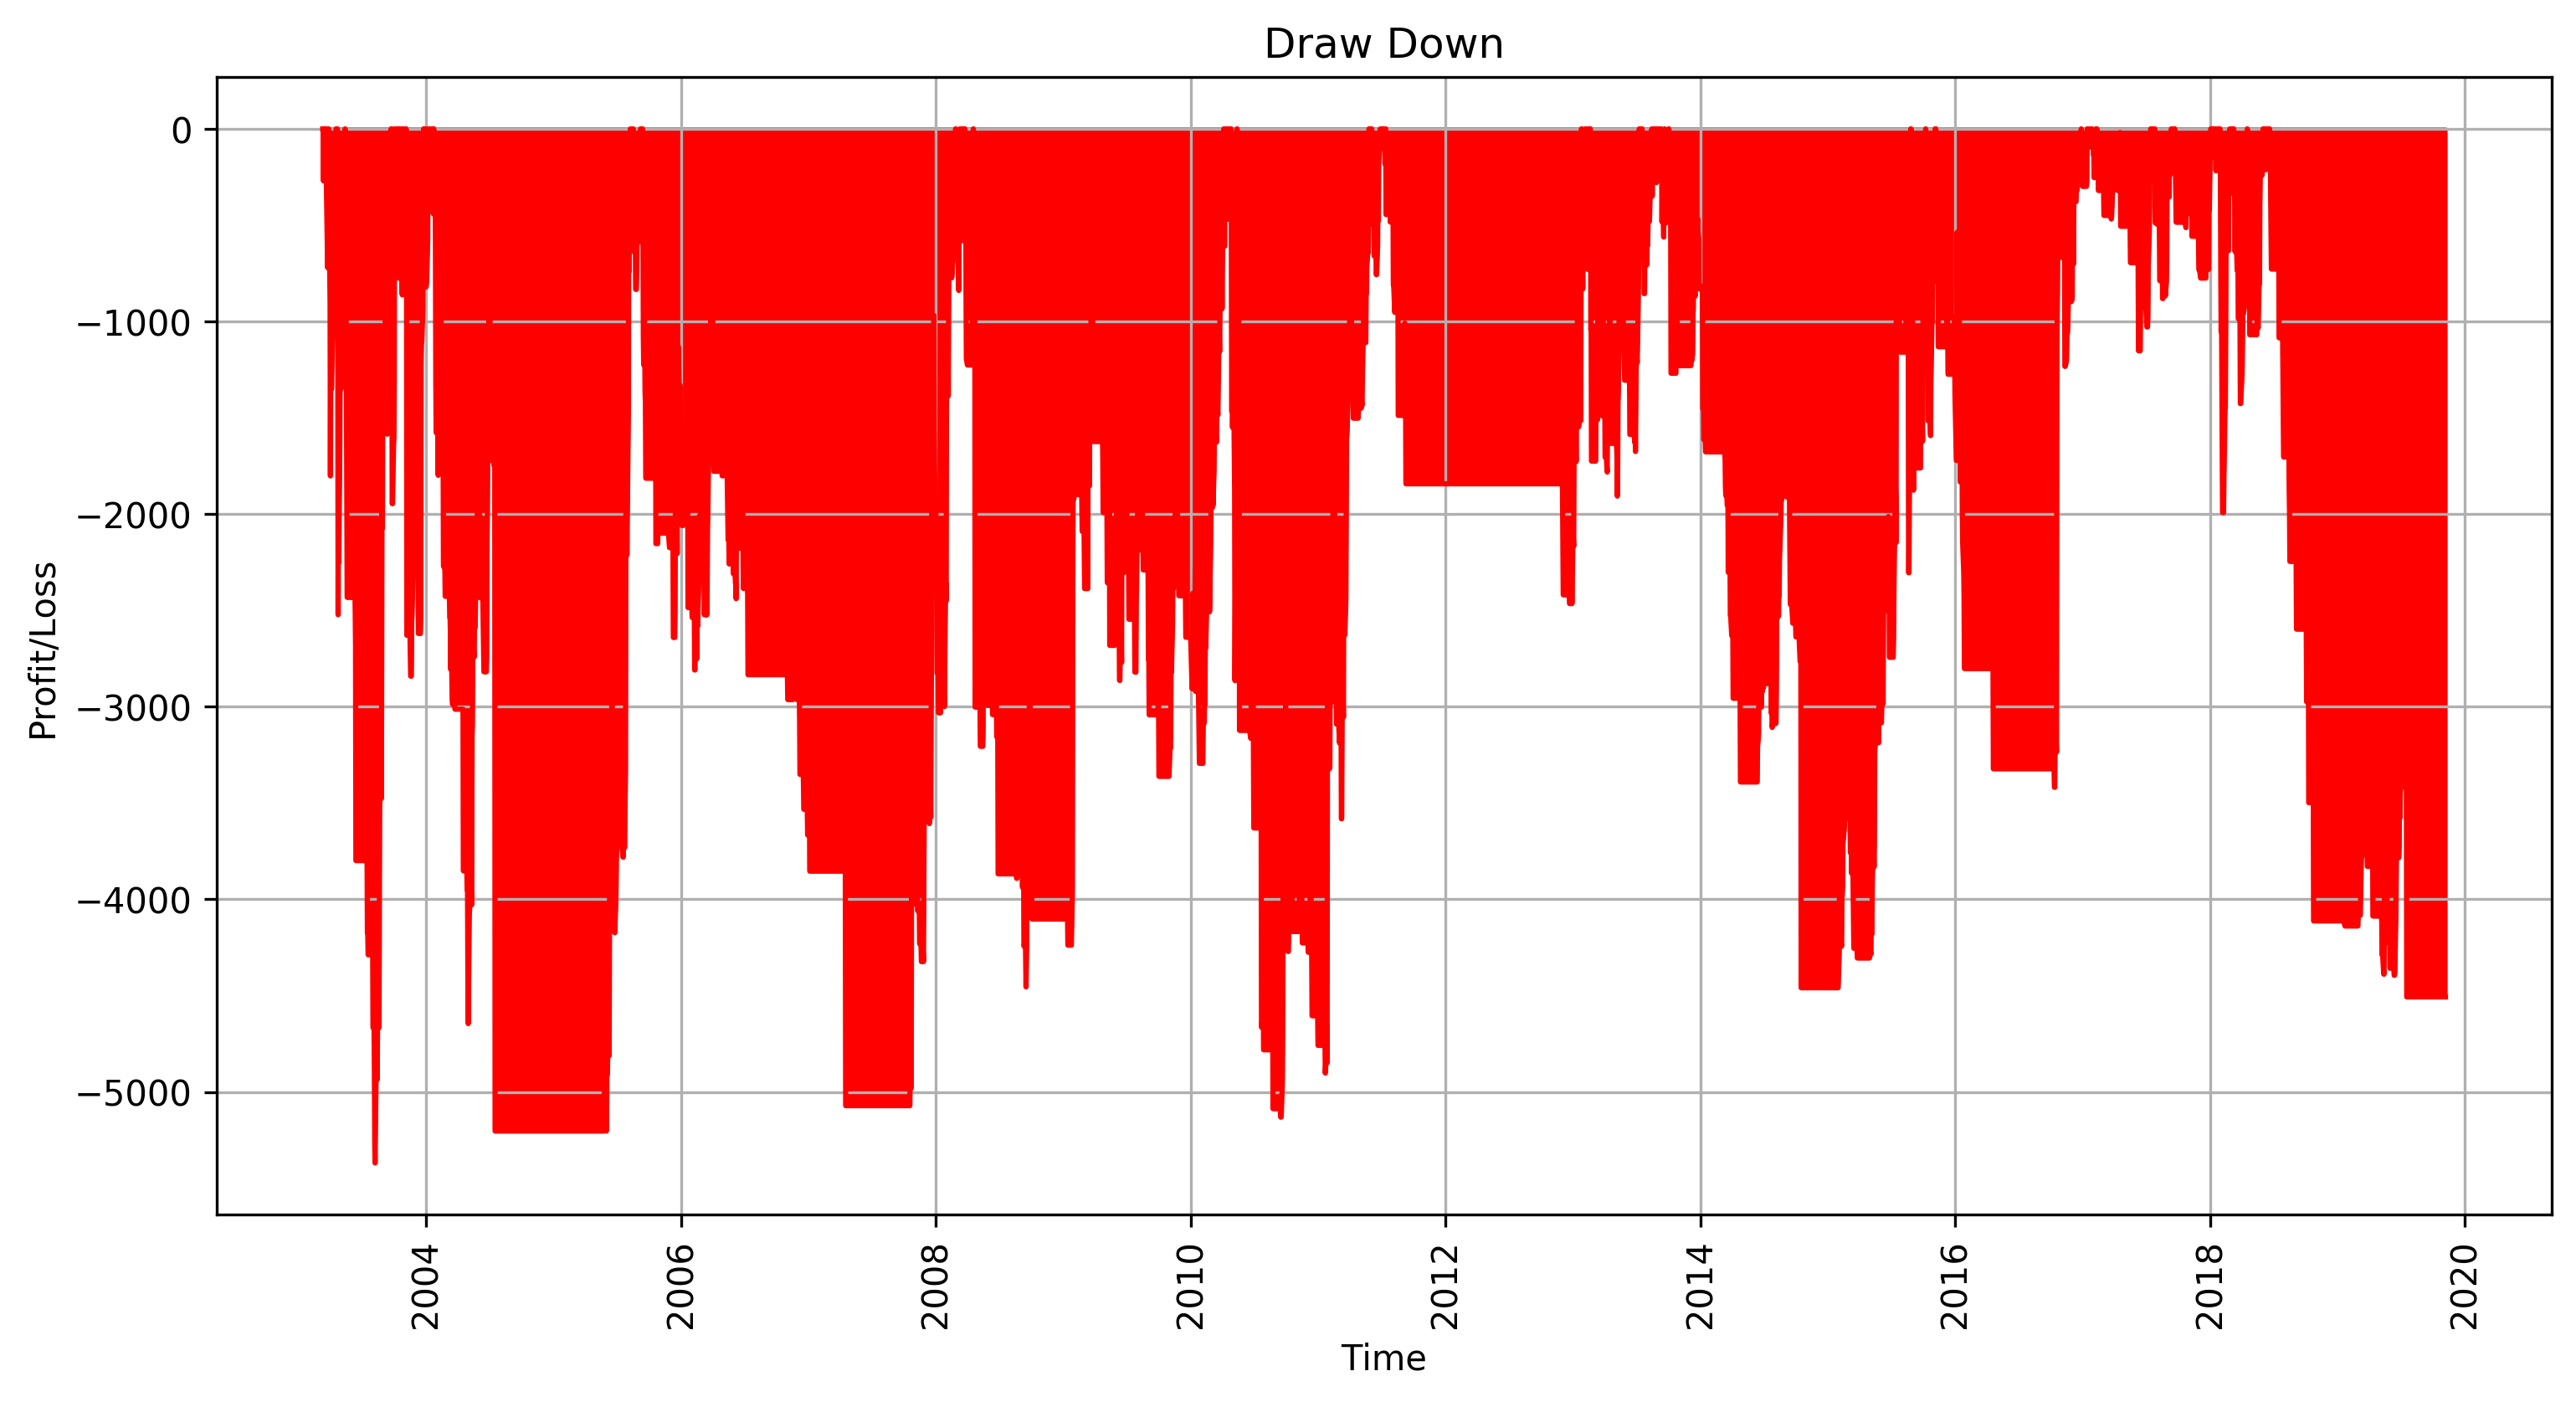

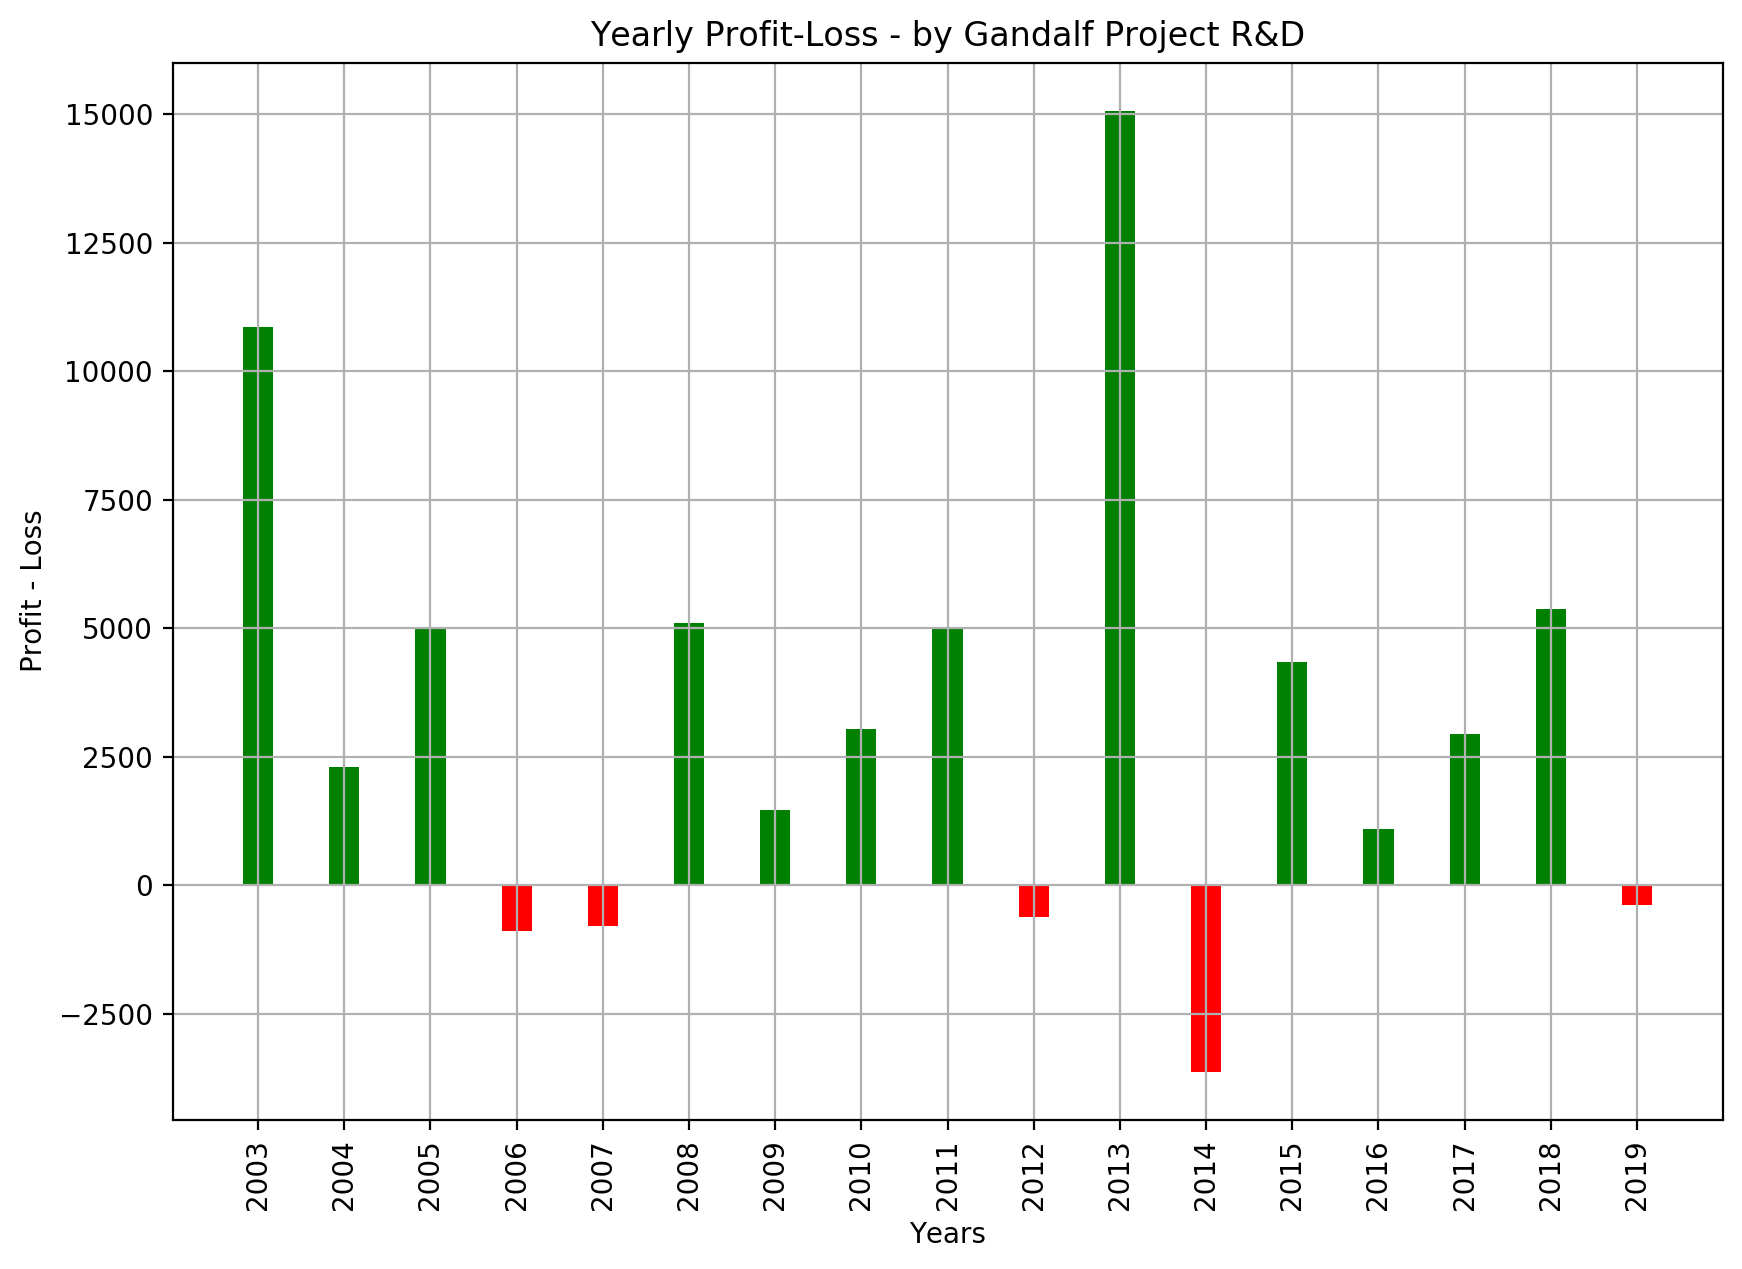

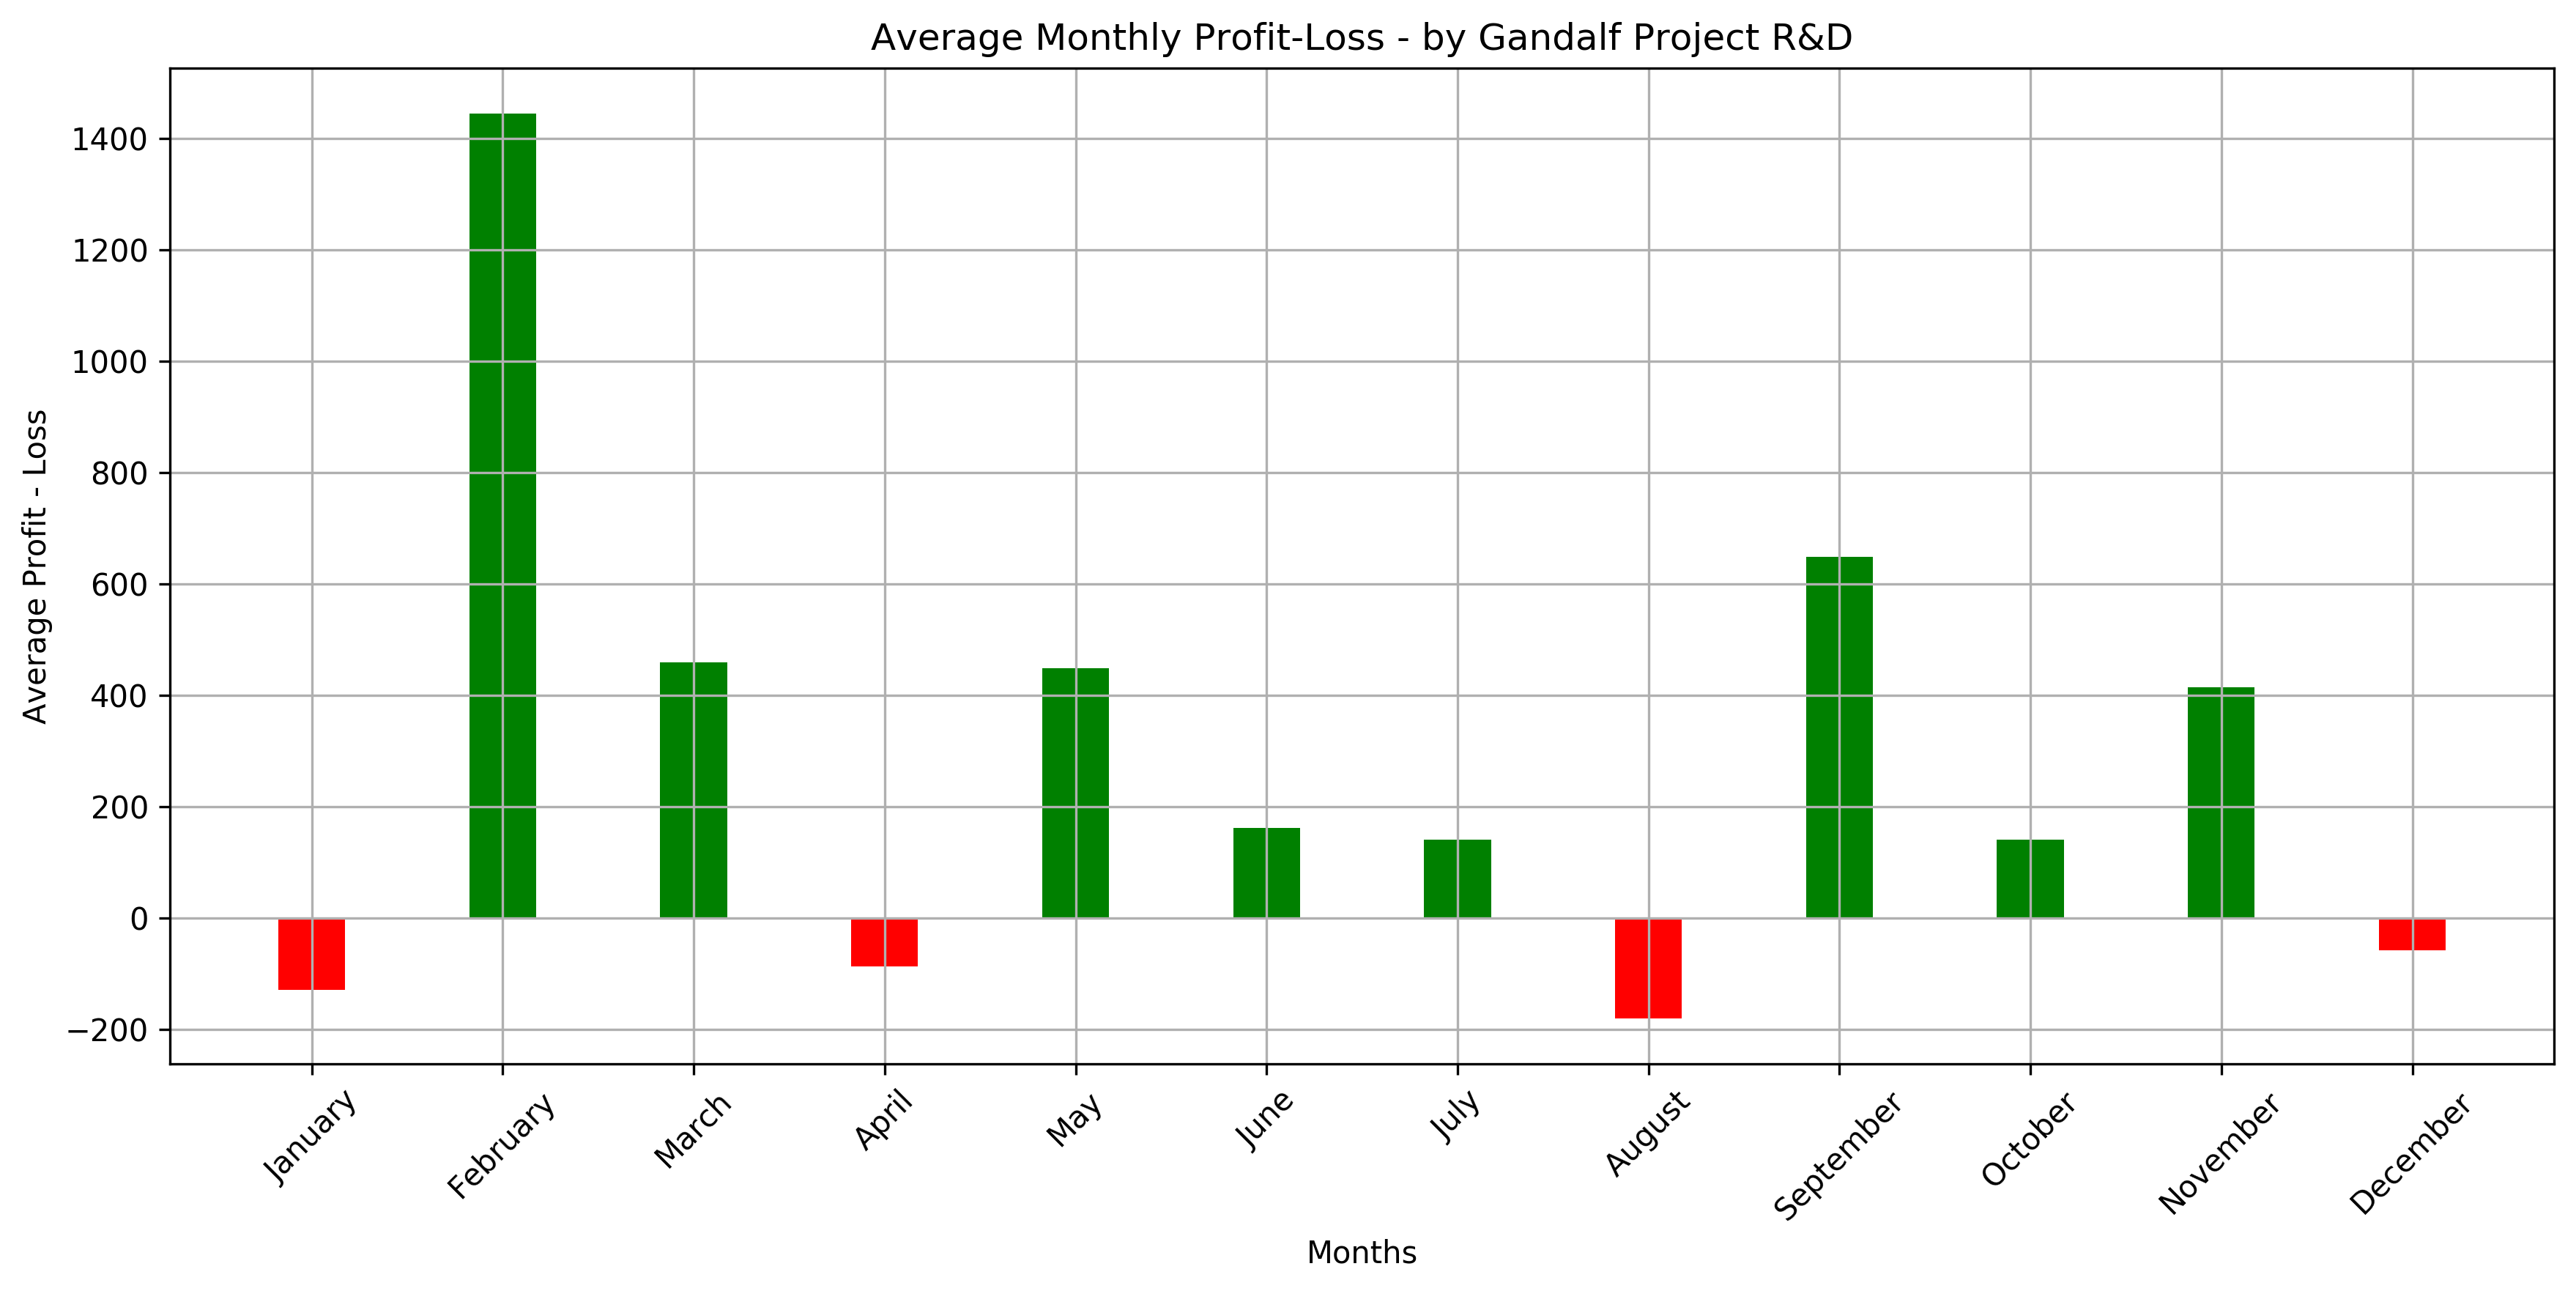

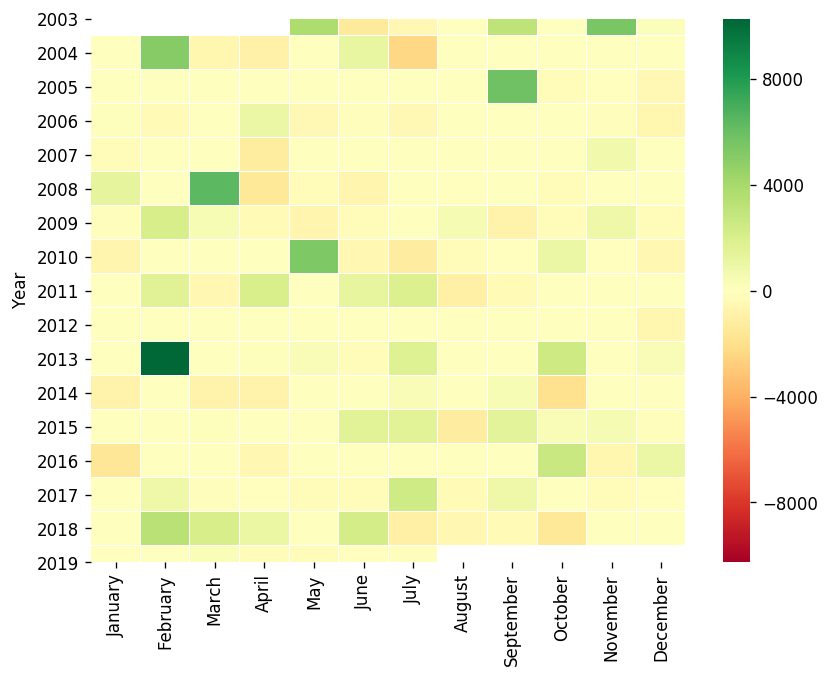

In [10]:
dataset = load_data_daily("NFLX_Daily.txt")

dataset["SMA200"] = dataset.close.rolling(200).mean()
dataset["SMA50"] = dataset.close.rolling(50).mean()
dataset["hhv20"] = dataset.high.rolling(20).max()
dataset["llv20"] = dataset.low.rolling(20).min()
dataset["hhv5"] = dataset.high.rolling(5).max()
dataset["llv5"] = dataset.low.rolling(5).min()
dataset.dropna(inplace=True)

COSTS = 0
INSTRUMENT = 1 # 1: equity/forex, 2: future
TICK = 0.01
OPERATION_MONEY = 10000
DIRECTION = "long"
ORDER_TYPE = "limit"

enter_rules = dataset.close > dataset.SMA200
enter_level = dataset.llv5.shift(1)
exit_rules = crossunder(dataset.close,dataset.llv5.shift(1))

trading_system = apply_trading_system(dataset, TICK, DIRECTION, ORDER_TYPE, enter_level, enter_rules, exit_rules)

operations = trading_system.operations.dropna()

performance_report(trading_system,operations,trading_system.closed_equity,trading_system.open_equity);